# Classification using Convolutional Neural Networks

We will now train our a convolutional neural network (CNN) classifier using PyTorch.  We will use the MNIST dataset for this.


In [1]:
import torch
import torchvision

For running this tutorial in colab, please be sure your runtime has a GPU. For this, go to [Runtime] then click [Change runtime type] and be sure you have any of the GPUs selected.  

If all this works, the next code cell should print *cuda*.

In [2]:
# Define the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## MNIST dataset
The MNIST dataset is a collection of *60.000* training images and *10.000* test images of handwritten digits (0–9), each in a 28x28 pixel grayscale format.

It was introduced in:
LeCun, Y., Bottou, L., Bengio, Y., & Haffner, P. (1998). Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11), 2278–2324. https://doi.org/10.1109/5.726791

This dataset is often used to learn how CNNs work, and to compare classification models. PyTorch has included it in its datasets.  Other datasets can be found here:
https://pytorch.org/vision/main/datasets.html

In [3]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

# Define the dataset and transformations
train_dataset = MNIST(root="data", train=True, download=True, transform=ToTensor())
test_dataset = MNIST(root="data", train=False, download=True, transform=ToTensor())

Let's visualise some images from the training dataset:

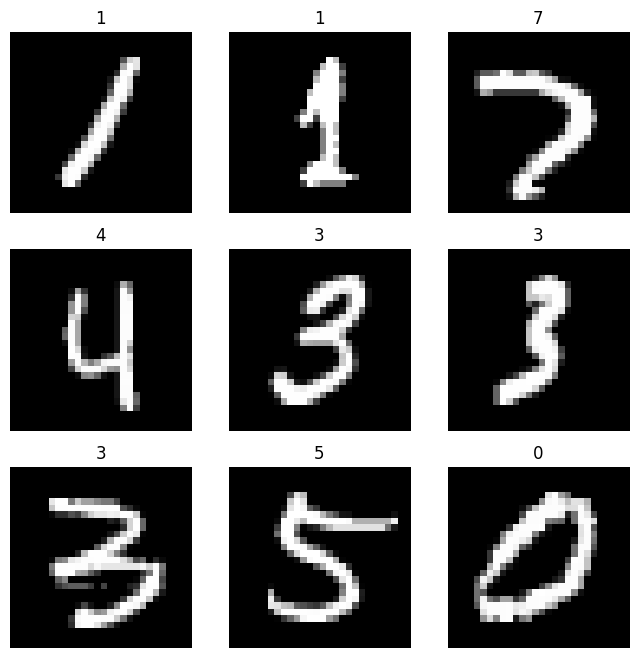

In [4]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()


## DataLoader
PyTorch has implemented a class called *DataLoader* to use mini-batch optimisation. We will use it for training our classifier.

You can find more info here:
- https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
- https://pytorch.org/tutorials/beginner/data_loading_tutorial.html



We will first divide our training set into train/validation.  We will use 'random_split' from PyTorch:

In [5]:
train, validation = torch.utils.data.random_split(train_dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(1234))

And now we use DataLoader with a given batch file:

In [6]:
batch_size = 64
trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=2)
validationloader = torch.utils.data.DataLoader(validation, batch_size=batch_size, shuffle=True, num_workers=2)

## Definining the CNN
We will implement a simple CNN with two Convolutional layers, and two fully connected layers.

In [7]:
import torch.nn as nn

class OurCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3) # 32 kernels in this layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3) # 64 kernels in this layer
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 10)  # 10: 10 labels 0-9

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        # Use adaptive pooling instead of maxpooling
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        # Flatten the tensor before passing it to the fully connected layers
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return nn.functional.log_softmax(x, dim=1)

We can now create the model. The model is an object of the class OurCNN, and we need to assign the device we are working with (this time it should be cuda).

In [8]:
amodel = OurCNN().to(device)
print(amodel)

OurCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## Training the neural network

Remember that training is optimising the values of the trainable parameters using some hyperparameters to define the model characteristics and guide the optimisation process.  Here we have already decided on the model characteristics when we defined OurCNN.  The next part is how to set up the training process.

### Training 1 epoch

We need to write what to do when the model is train for one epoch (that is, when the optimiser sees the complete dataset and updates the parameters).  In this case, we want to compute the average error (loss function) across all backpropagation steps.

In [9]:
import numpy as np
def train_1epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    sumloss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # accumulate the loss for this epoch
        sumloss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return sumloss / num_batches


### Evaluating without changing parameters
We should also check the model's performance against the validation dataset to be sure it is learning and assess wether it is underfiting, overfitting, or doing just right.

In [10]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

### Training loop

Finally, we need to make the trainable loop:

In [11]:
import torch.optim as optim

def train_loop(traindataloader,valdataloader,model,epochs):
  optimiser = optim.Adam(model.parameters(), lr=1e-3)
  loss_fn = nn.CrossEntropyLoss()
  trainloss = []
  validationloss = []
  valaccuracies = []
  for t in range(epochs):
      print(f"Epoch {t+1}\n-------------------------------")
      tl = train_1epoch(traindataloader, model, loss_fn, optimiser)
      vl, va = test(valdataloader, model, loss_fn)
      print(f"Epoch {t+1}\tLosses:  Training {tl}, Validation {vl}." )
      trainloss.append(tl)
      validationloss.append(vl)
      valaccuracies.append(va)
  print("Training done!")
  return trainloss, validationloss, valaccuracies


In [12]:
epochs = 10
ourmodel = OurCNN().to(device)
trainloss, validationloss, valaccuracies = train_loop(trainloader,validationloader,ourmodel,epochs)

Epoch 1
-------------------------------
loss: 2.303400  [   64/48000]
loss: 1.993733  [ 6464/48000]
loss: 2.030178  [12864/48000]
loss: 1.731714  [19264/48000]
loss: 1.785775  [25664/48000]
loss: 1.728740  [32064/48000]
loss: 1.441796  [38464/48000]
loss: 1.473769  [44864/48000]
Validation Error: 
 Accuracy: 44.4%, Avg loss: 1.477071 

Epoch 1	Losses:  Training 1.7634831741650898, Validation 1.4770706834945273.
Epoch 2
-------------------------------
loss: 1.501681  [   64/48000]
loss: 1.509778  [ 6464/48000]
loss: 1.335479  [12864/48000]
loss: 1.358205  [19264/48000]
loss: 1.286963  [25664/48000]
loss: 1.309751  [32064/48000]
loss: 1.176131  [38464/48000]
loss: 1.467392  [44864/48000]
Validation Error: 
 Accuracy: 51.4%, Avg loss: 1.266430 

Epoch 2	Losses:  Training 1.3602787636121114, Validation 1.2664303567181243.
Epoch 3
-------------------------------
loss: 1.228753  [   64/48000]
loss: 1.050030  [ 6464/48000]
loss: 1.114752  [12864/48000]
loss: 1.285953  [19264/48000]
loss: 1.28

### Plotting learning curves
Let's try and identify if we trained the best possible

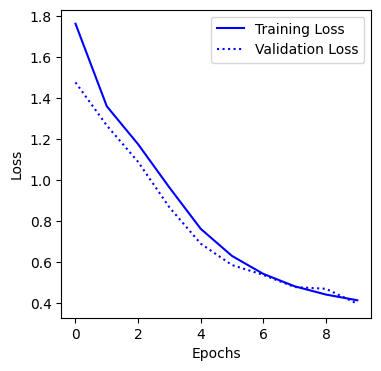

In [13]:
import matplotlib.pyplot as plt  # type: ignore

fig, axs = plt.subplots(1,1,figsize=(4, 4)) # plotting multiple panels: 1 row, 2 columns
axs.plot(trainloss,'b-',label="Training Loss")
axs.plot(validationloss,'b:', label="Validation Loss")

axs.set_xlabel("Epochs")
axs.set_ylabel("Loss")
axs.legend()

plt.show()

What do these curves tell you? 🤔

## Implementing K-fold cross validation

PyTorch does not include an implementation of KFold within their dataloaders.  Instead, we can use KFold from SKLearn to help us, as proposed [here](https://saturncloud.io/blog/how-to-use-kfold-cross-validation-with-dataloaders-in-pytorch/).

In [14]:
from sklearn.model_selection import KFold

# Define the number of folds and batch size
k_folds = 5

# Initialize the k-fold cross validation
kf = KFold(n_splits=k_folds, shuffle=True)

foldtrainingloss = []
foldvalidationloss = []
foldvalidationaccuracy = []
# Loop through each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"Fold {fold + 1}")
    print("-------")

    # Define the data loaders for the current fold
    foldtrainloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size,sampler=torch.utils.data.SubsetRandomSampler(train_idx))
    foldvalidationloader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,sampler=torch.utils.data.SubsetRandomSampler(val_idx))

    # Initialize the model
    foldmodel = OurCNN().to(device)

    # run it for few epochs to make it during class
    epochs = 5
    foldtl, foldvl, foldva = train_loop(foldtrainloader,foldvalidationloader,foldmodel,epochs)

    # keep the losses to plot them
    foldtrainingloss.append(foldtl)
    foldvalidationloss.append(foldvl)
    foldvalidationaccuracy.append(foldva)
print('Done!')


Fold 1
-------
Epoch 1
-------------------------------
loss: 2.306115  [   64/60000]
loss: 2.071004  [ 6464/60000]
loss: 1.986961  [12864/60000]
loss: 1.632159  [19264/60000]
loss: 1.594598  [25664/60000]
loss: 1.626790  [32064/60000]
loss: 1.565113  [38464/60000]
loss: 1.458818  [44864/60000]
Validation Error: 
 Accuracy: 8.7%, Avg loss: 1.482215 

Epoch 1	Losses:  Training 1.7741325736045837, Validation 1.4822151305827689.
Epoch 2
-------------------------------
loss: 1.302628  [   64/60000]
loss: 1.521953  [ 6464/60000]
loss: 1.300562  [12864/60000]
loss: 1.402934  [19264/60000]
loss: 1.437140  [25664/60000]
loss: 1.209868  [32064/60000]
loss: 1.423678  [38464/60000]
loss: 1.437453  [44864/60000]
Validation Error: 
 Accuracy: 11.0%, Avg loss: 1.226605 

Epoch 2	Losses:  Training 1.3465191151301066, Validation 1.2266049280445626.
Epoch 3
-------------------------------
loss: 1.367557  [   64/60000]
loss: 1.277726  [ 6464/60000]
loss: 1.116167  [12864/60000]
loss: 1.000222  [19264/600

Let's plot these now:

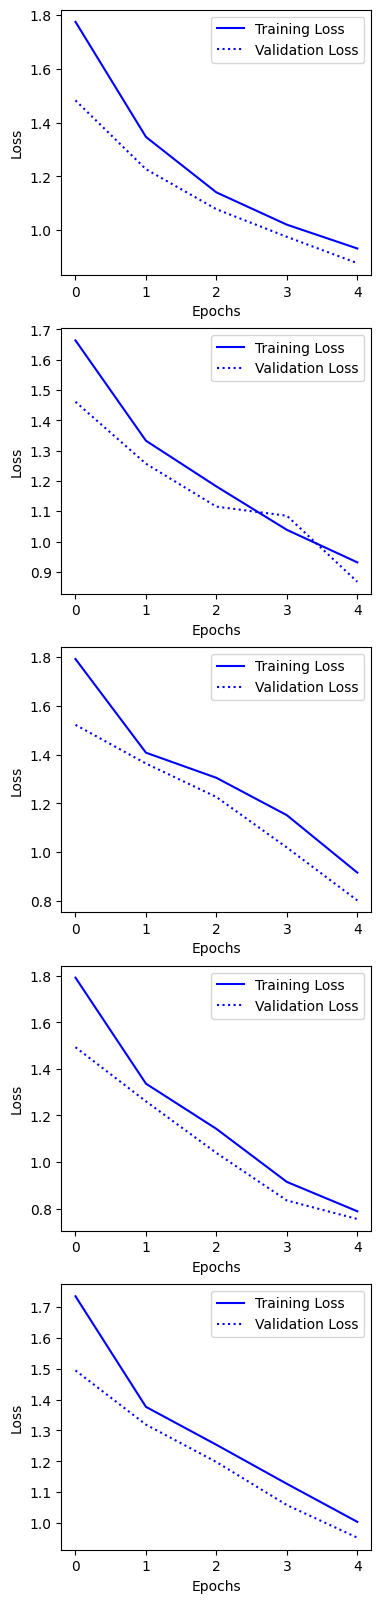

In [15]:
import matplotlib.pyplot as plt  # type: ignore

fig, axs = plt.subplots(k_folds,1,figsize=(4,4*k_folds)) # plotting multiple panels: k_fold rows
for foldi in range(k_folds):
  axs[foldi].plot(foldtrainingloss[foldi],'b-',label="Training Loss")
  axs[foldi].plot(foldvalidationloss[foldi],'b:', label="Validation Loss")

  axs[foldi].set_xlabel("Epochs")
  axs[foldi].set_ylabel("Loss")
  axs[foldi].legend()

plt.show()


# Final thoughts

There are many resources to learn more about CNNs using PyTorch.  
I recommend you to look in the PyTorch tutorials for some help:
- https://pytorch.org/tutorials/beginner/basics/intro.html
- https://pytorch.org/tutorials/
- https://pytorch.org/vision/main/models.html to explore transfer learning.

Small tips related to the final project:
- When you are happy with one of the models, you should save the weights.  For this, use torch.save.  Check this tutorial for that: https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html
- You can think of creating your own DataSet (or DataLoader) for including biases in training. Check https://pytorch.org/tutorials/beginner/basics/data_tutorial.html or play with the sampler as we did here for the K-fold.
